### Can we classify each phase as relatively low or high anxiety for each subject? ###

In [27]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys

import tools.data_reader_apd as dr_a
import tools.data_reader_wesad as dr_w
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
# metrics = train.Metrics.ALL
# metrics = train.Metrics.ECG \
    # + train.Metrics.EDA \
    # + train.Metrics.ANKLE + train.Metrics.WRIAAST

metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
]

model_phases_apd = [
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
        "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
    ],
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", "BugBox_Break",
        "Speech_Relax", "Speech_Anticipate", "Speech_Break"
    ],
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", 
        "Speech_Relax", "Speech_Anticipate"
    ],
    # [
    #     "Baseline_Rest", 
    #     "BugBox_Relax", "BugBox_Anticipate", "BugBox_Break",
    #     "Speech_Relax", "Speech_Anticipate", "Speech_Break"
    # ],
    ["BugBox_Break", "Speech_Break"],
    ["BugBox_Exposure", "Speech_Exposure"]
]

model_phases_wesad = [
    [
        dr_w.Phases.BASE,
        dr_w.Phases.FUN,
        dr_w.Phases.TSST,
        dr_w.Phases.MEDI_1,
        dr_w.Phases.MEDI_2
    ],
    [
        dr_w.Phases.BASE,
        dr_w.Phases.TSST,
        dr_w.Phases.MEDI_1,
        dr_w.Phases.MEDI_2
    ],
    [
        dr_w.Phases.BASE,
        dr_w.Phases.MEDI_1,
        dr_w.Phases.MEDI_2
    ],
    [
        dr_w.Phases.BASE,
    ]
]

apd_label_type = "Anxiety"
wesad_label_type = "stai"

models = {
    "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    "Bayes": GaussianNB(),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss")
}

test_size = 1.0

`use_label_encoder` is deprecated in 1.7.0.


In [ ]:
# TRAIN ON APD AND TEST ON WESAD
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_w)
importlib.reload(dt)


for i, phases_apd in enumerate(model_phases_apd):
    for j, phases_wesad in enumerate(model_phases_wesad):
        print(f"APD PHASES {i} " + "-"*50)
        print(f"WESAD PHASES {j} " + "-"*50)
        x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=apd_label_type)
        x_b, y_b = train.Train_WESAD.get_wesad_data(metrics, phases_wesad, verbose=False, label_type=wesad_label_type)
        # drop subjects with noisy data
        x_a = x_a[x_a['subject'] != 84.0]
        x_a = x_a.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature
        y_a = y_a[y_a['subject'] != 84.0]
        # x = x[x['subject'] != 8.0]
        # y = y[y['subject'] != 8.0]

        # 0-1 scaling
        for c in range(3, len(x_a.columns)):
            data_col = x_a[x_a.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_a[x_a.columns[c]] = data_col
        # 0-1 scaling
        for c in range(3, len(x_b.columns)):
            data_col = x_b[x_b.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_b[x_b.columns[c]] = data_col

        acc_results = {
            "SVM": [], "KNN": [],
            "DT": [],
            "LogReg": [],
            "Bayes": [],
            "XGB": []
        }
        reports = {
            "SVM": [], "KNN": [],
            "DT": [],
            "LogReg": [],
            "Bayes": [],
            "XGB": [],
        }
        num_iters = 10
        for _ in range(num_iters):
            out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size)
            for model_name in acc_results:
                acc_results[model_name].append(out[model_name][0])
                reports[model_name].append(out[model_name][1])

        for model_name in acc_results.keys():
            acc = np.mean(acc_results[model_name])
            print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
            if acc > 0.65:
                print(f"Model evaluation metrics for {model_name}:")
                p = np.mean([report["precision"] for report in reports[model_name]])
                r = np.mean([report["recall"] for report in reports[model_name]])
                f1 = np.mean([report["f1"] for report in reports[model_name]])
                auc = np.mean([report["auc"] for report in reports[model_name]])
                report = reports[model_name]
                print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
        print("\n")

In [ ]:
# TRAIN ON WESAD AND TEST ON APD
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_w)
importlib.reload(dt)


for i, phases_wesad in enumerate(model_phases_wesad):
    for j, phases_apd in enumerate(model_phases_apd):
        print(f"WESAD PHASES {i} " + "-"*50)
        print(f"APD PHASES {j} " + "-"*50)
        x_a, y_a = train.Train_WESAD.get_wesad_data(metrics, phases_wesad, verbose=False, label_type=wesad_label_type)
        x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=apd_label_type)
        # drop subjects with noisy data
        x_b = x_b[x_b['subject'] != 84.0]
        x_b = x_b.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature
        y_b = y_b[y_b['subject'] != 84.0]
        # x = x[x['subject'] != 8.0]
        # y = y[y['subject'] != 8.0]

        # 0-1 scaling
        for c in range(3, len(x_a.columns)):
            data_col = x_a[x_a.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_a[x_a.columns[c]] = data_col
        # 0-1 scaling
        for c in range(3, len(x_b.columns)):
            data_col = x_b[x_b.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_b[x_b.columns[c]] = data_col

        acc_results = {
            "SVM": [], "KNN": [],
            "DT": [],
            "LogReg": [],
            "XGB": []
        }
        reports = {
            "SVM": [], "KNN": [],
            "DT": [],
            "LogReg": [],
            "XGB": [],
        }
        num_iters = 10
        for _ in range(num_iters):
            out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size)
            for model_name in acc_results:
                acc_results[model_name].append(out[model_name][0])
                reports[model_name].append(out[model_name][1])

        for model_name in acc_results.keys():
            acc = np.mean(acc_results[model_name])
            print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
            if acc > 0.65:
                p = np.mean([report["precision"] for report in reports[model_name]])
                r = np.mean([report["recall"] for report in reports[model_name]])
                f1 = np.mean([report["f1"] for report in reports[model_name]])
                auc = np.mean([report["auc"] for report in reports[model_name]])
                report = reports[model_name]
                print(f"Report:\nPrecision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
        print("\n")

WESAD PHASES 0 --------------------------------------------------
APD PHASES 0 --------------------------------------------------
0    176
1    325
Name: label, dtype: int64


Exact explainer: 359it [11:22,  1.93s/it]                         
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Exact explainer: 360it [11:14,  1.91s/it]                         
Exact explainer: 360it [11:12,  1.90s/it]                         
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Exact explainer: 361it [11:07,  1.88s/it]                         
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Exact explainer: 361it [11:15,  1.90s/it]                         
Exact explainer: 359it [2:19:24, 23.70s/it]                               
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Exact explainer: 359it [11:11,  1.90s/it]                         
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Exact explainer: 361it [11:11,  1.89s/it]                         
ntree_

SVM accuracy over 10 rounds: 0.6709381055915165
Report:
Precision: 0.677573196788406
Recall: 0.9799268194668038
F1-score: 0.8010690510195568
AUC score: 0.5029971257456822



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


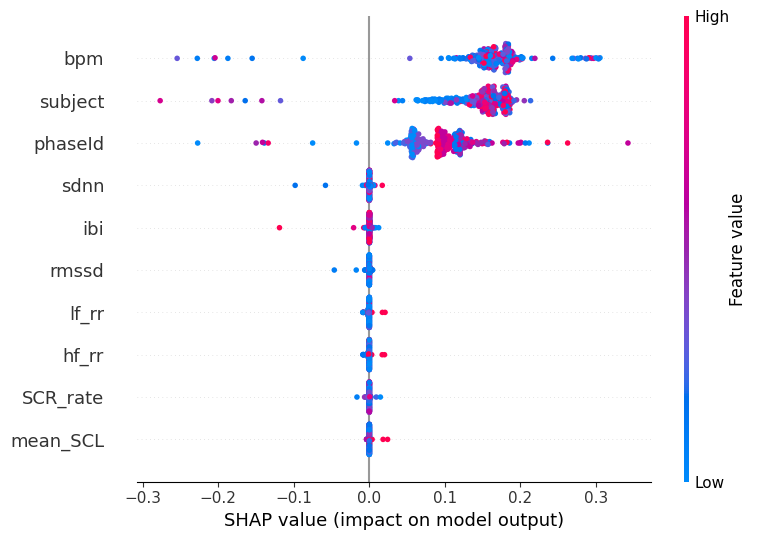

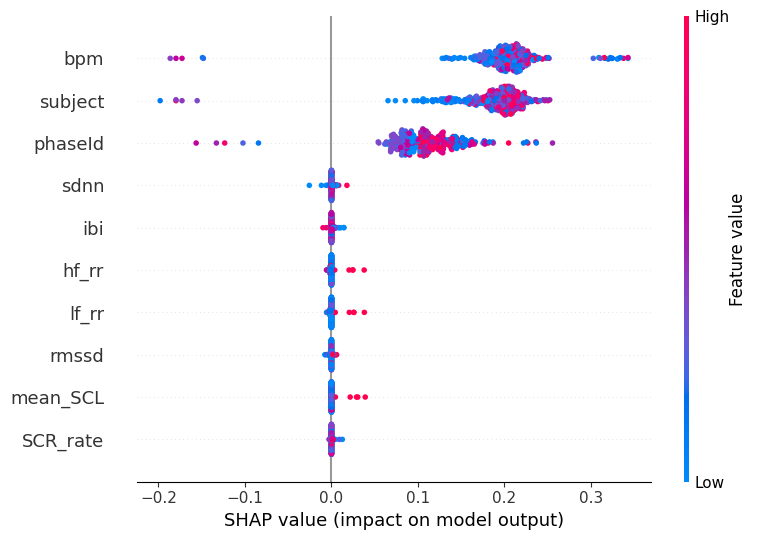

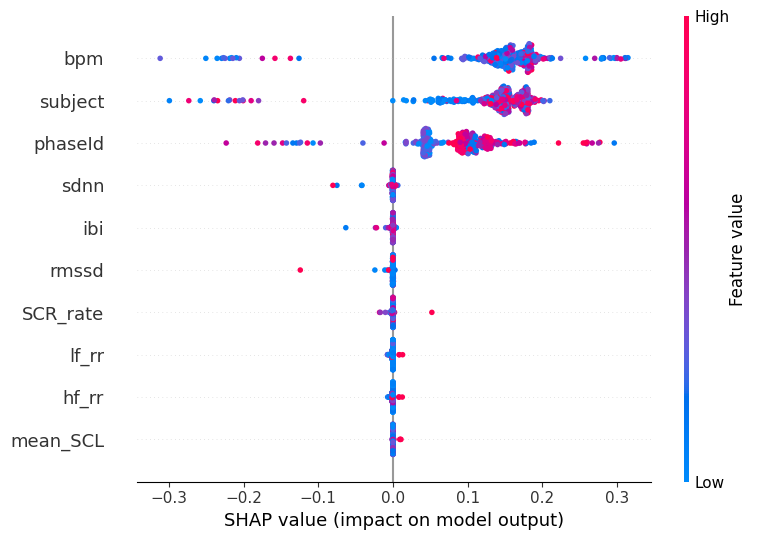

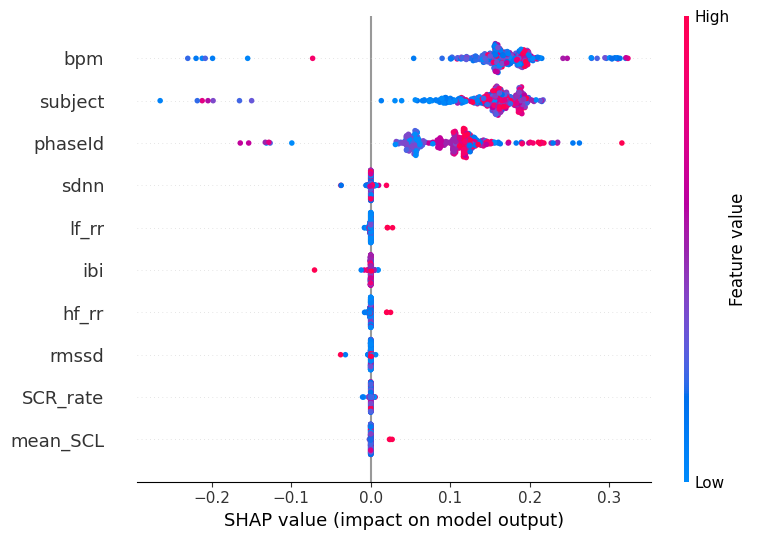

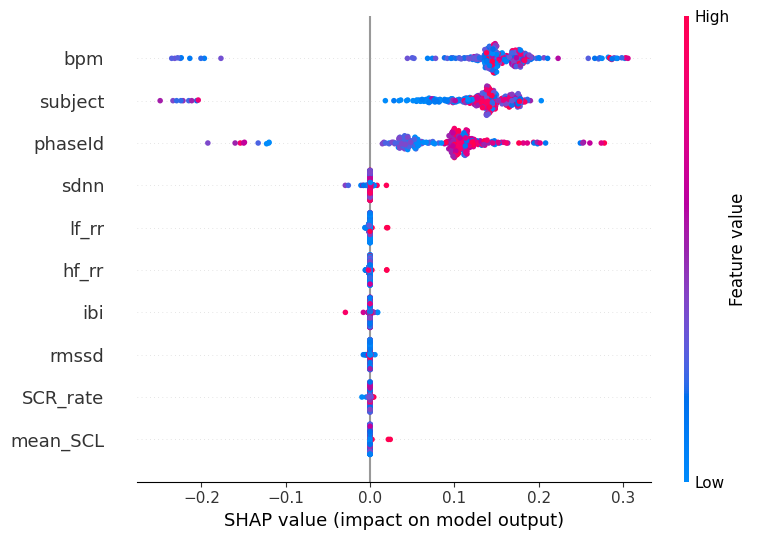

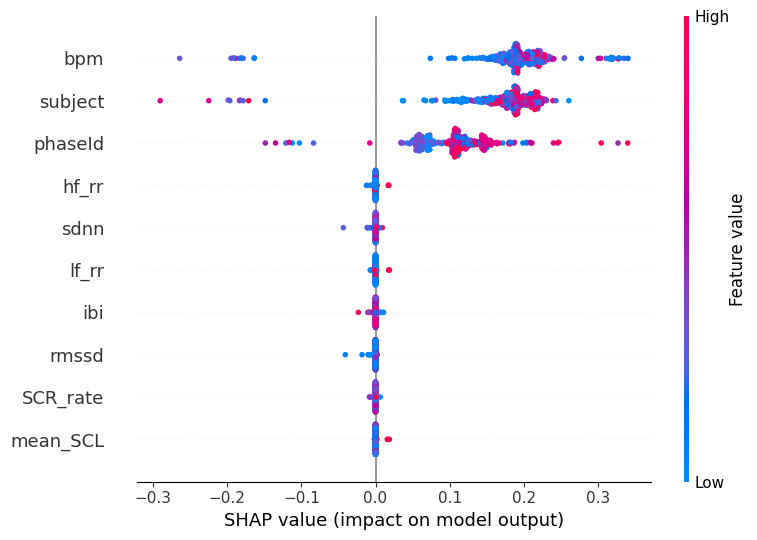

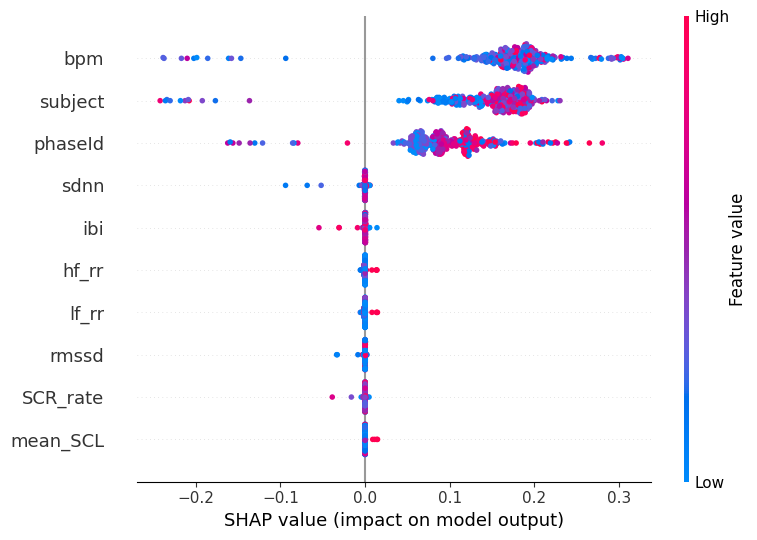

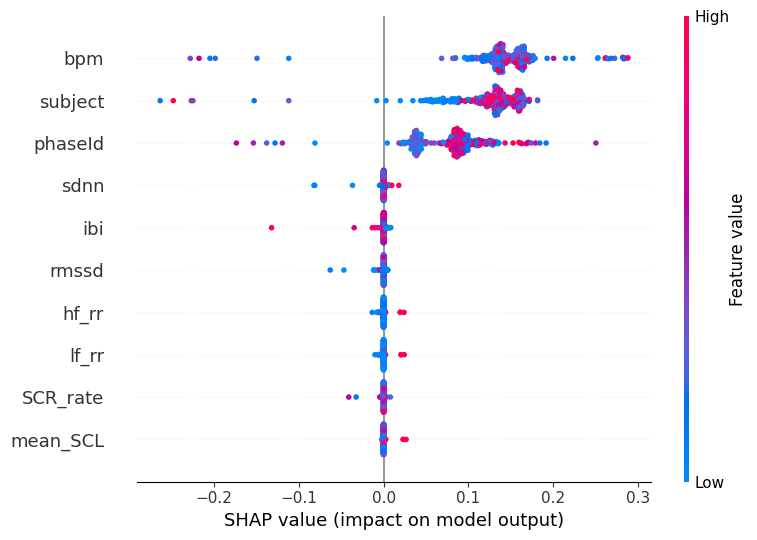

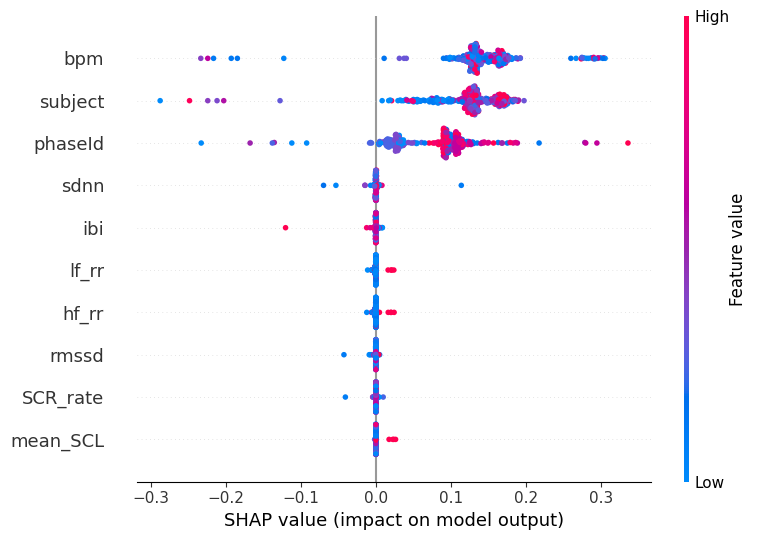

XGB accuracy over 10 rounds: 0.66152532981109
Report:
Precision: 0.7420540142918766
Recall: 0.7685202736673167
F1-score: 0.7538790475391417
AUC score: 0.6045491670963536



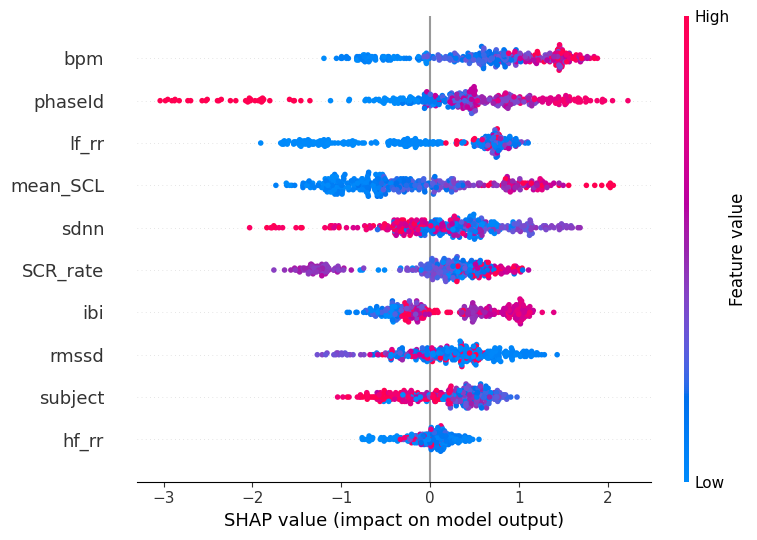

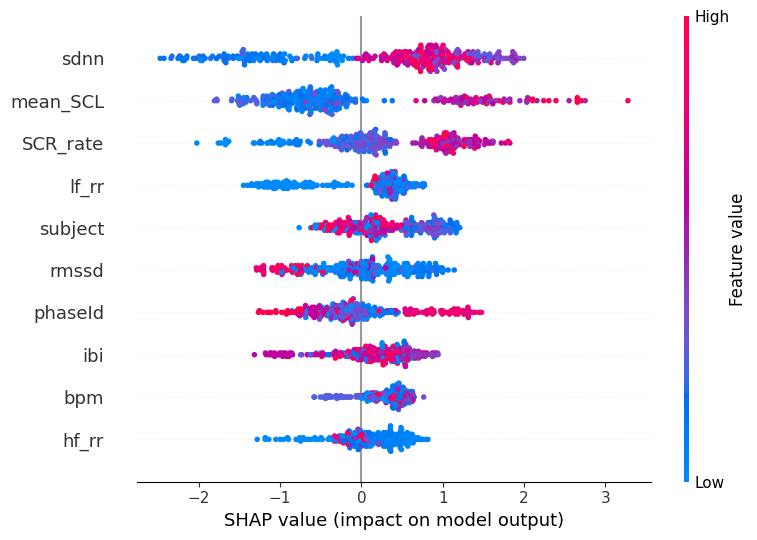

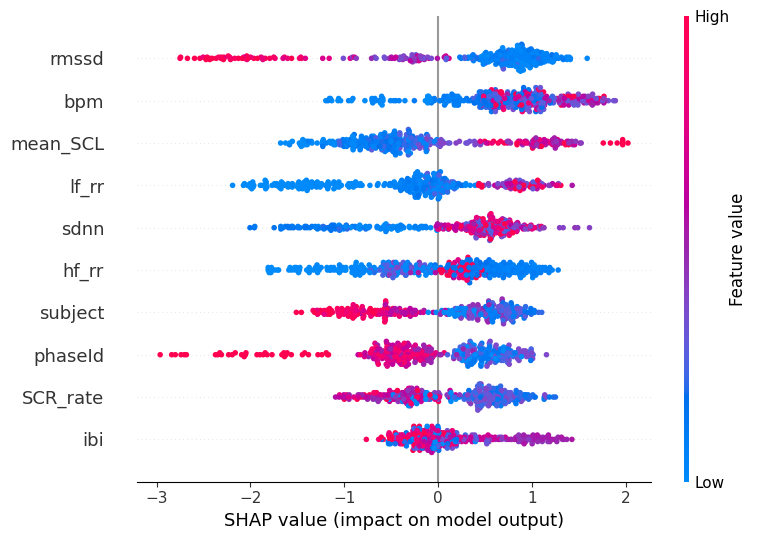

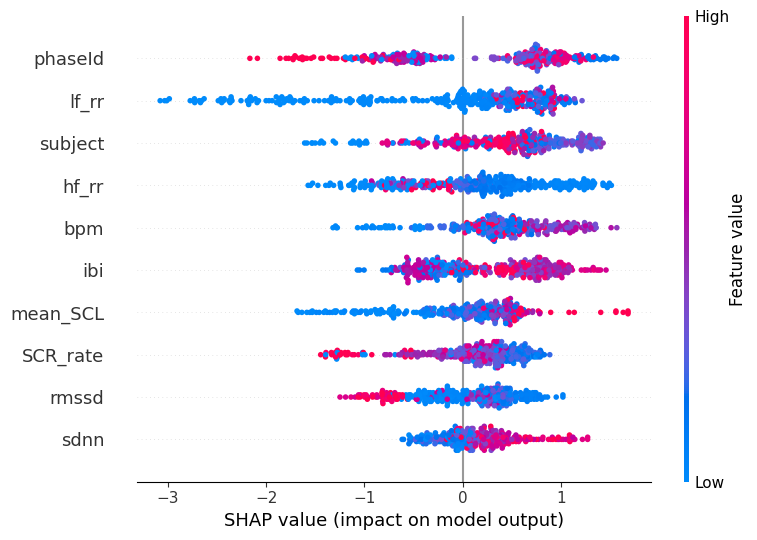

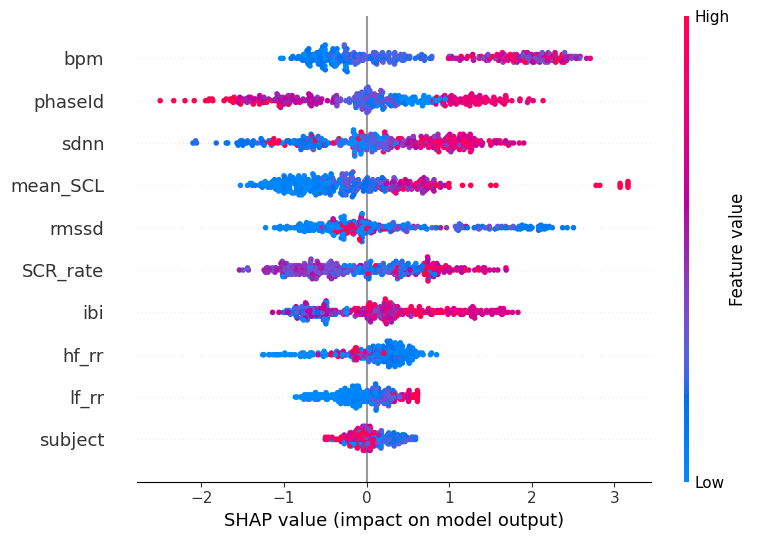

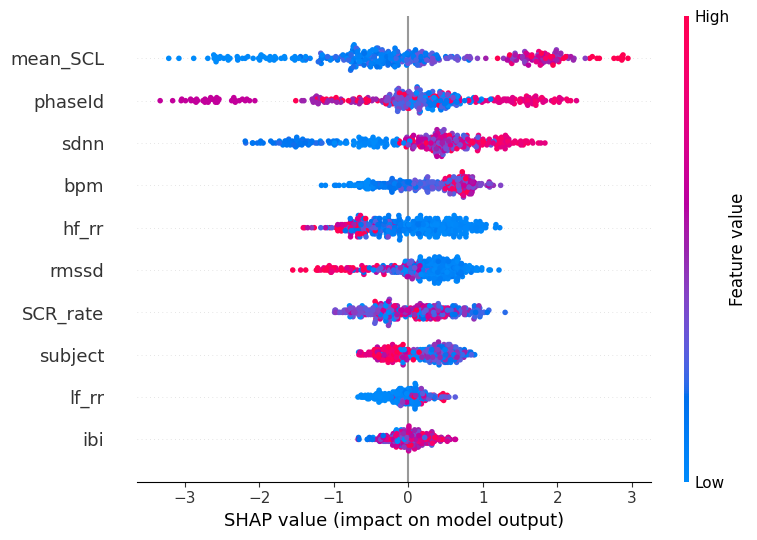

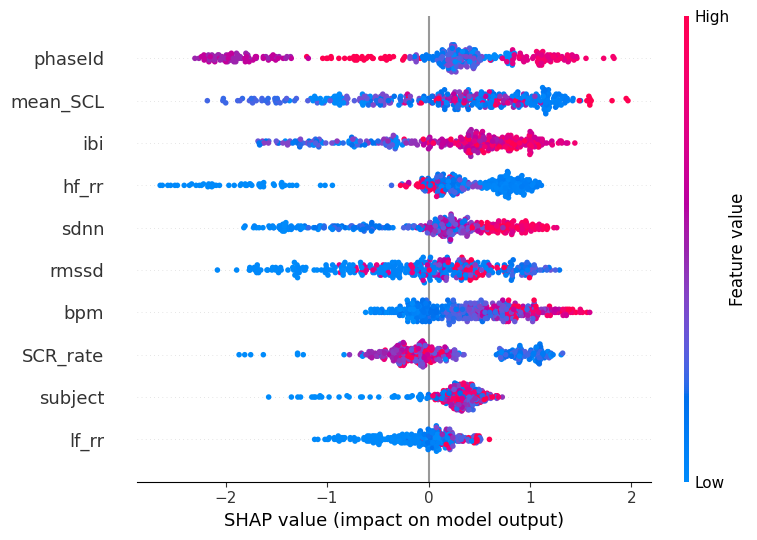

In [40]:
# CLOSER ANALYSIS OF:
# APD 1, 20% AND WESAD 3, 100%
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_w)
importlib.reload(dt)


test_size = 0.80

apd_label_type = "Anxiety"
wesad_label_type = "stai"

get_shap_values = True

model_phases_apd = [
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
        "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
    ]
]

model_phases_wesad = [
    [
        dr_w.Phases.BASE, dr_w.Phases.MEDI_1, dr_w.Phases.MEDI_2
    ]
]

for i, phases_wesad in enumerate(model_phases_wesad):
    for j, phases_apd in enumerate(model_phases_apd):
        print(f"WESAD PHASES {i} " + "-"*50)
        print(f"APD PHASES {j} " + "-"*50)
        x_a, y_a = train.Train_WESAD.get_wesad_data(metrics, phases_wesad, verbose=False, label_type=wesad_label_type)
        x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=apd_label_type)
        
        # drop subjects with noisy data
        x_b = x_b[x_b['subject'] != 84.0]
        x_b = x_b.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature
        y_b = y_b[y_b['subject'] != 84.0]
        # x = x[x['subject'] != 8.0]
        # y = y[y['subject'] != 8.0]

        print(y_a.loc[:, "label"].value_counts() + y_b.loc[:, "label"].value_counts())

        # 0-1 scaling
        for c in range(3, len(x_a.columns)):
            data_col = x_a[x_a.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_a[x_a.columns[c]] = data_col
        # 0-1 scaling
        for c in range(3, len(x_b.columns)):
            data_col = x_b[x_b.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_b[x_b.columns[c]] = data_col

        acc_results = {
            "SVM": [],
            "XGB": []
        }
        reports = {
            "SVM": [],
            "XGB": [],
        }
        shap_values = {
            "SVM": [],
            "XGB": [],
        }
        num_iters = 10
        for _ in range(num_iters):
            out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size, get_shap_values=get_shap_values)
            for model_name in acc_results:
                acc_results[model_name].append(out[model_name][0])
                reports[model_name].append(out[model_name][1])
                shap_values[model_name].append(out[model_name][2])

        for model_name in acc_results.keys():
            acc = np.mean(acc_results[model_name])
            print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
            if acc > 0.65:
                p = np.mean([report["precision"] for report in reports[model_name]])
                r = np.mean([report["recall"] for report in reports[model_name]])
                f1 = np.mean([report["f1"] for report in reports[model_name]])
                auc = np.mean([report["auc"] for report in reports[model_name]])
                report = reports[model_name]
                print(f"Report:\nPrecision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}\n")
            for i in range(len(shap_values[model_name])):
                if shap_values[model_name][i] is not None:
                    shap.summary_plot(shap_values[model_name][i])
        print("\n")

In [ ]:
model_name = "SVM"
idx = random.sample()
for i in range(len(shap_values[model_name])):
    if shap_values[model_name][i] is not None:
        shap.summary_plot(shap_values[model_name][i])

In [21]:
# CLOSER ANALYSIS OF:
# APD 2, 100%, WESAD 3, 0%
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_w)
importlib.reload(dt)

model_phases_apd = [
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", "BugBox_Break",
        "Speech_Relax", "Speech_Anticipate", "Speech_Break"
    ]
]

model_phases_wesad = [
    [
        dr_w.Phases.BASE, dr_w.Phases.MEDI_1, dr_w.Phases.MEDI_2
    ]
]

test_size = 1.0

apd_label_type = "Anxiety"
wesad_label_type = "stai"

get_shap_values = False

for i, phases_apd in enumerate(model_phases_apd):
    for j, phases_wesad in enumerate(model_phases_wesad):
        print(f"APD PHASES {i} " + "-"*50)
        print(f"WESAD PHASES {j} " + "-"*50)
        x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=apd_label_type)
        x_b, y_b = train.Train_WESAD.get_wesad_data(metrics, phases_wesad, verbose=False, label_type=wesad_label_type)
        # drop subjects with noisy data
        x_a = x_a[x_a['subject'] != 84.0]
        x_a = x_a.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature
        y_a = y_a[y_a['subject'] != 84.0]
        # x = x[x['subject'] != 8.0]
        # y = y[y['subject'] != 8.0]

        print(y_a.loc[:, "label"].value_counts() + y_b.loc[:, "label"].value_counts())
        
        # 0-1 scaling
        for c in range(3, len(x_a.columns)):
            data_col = x_a[x_a.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_a[x_a.columns[c]] = data_col
        # 0-1 scaling
        for c in range(3, len(x_b.columns)):
            data_col = x_b[x_b.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_b[x_b.columns[c]] = data_col

        acc_results = {
            "DT": [],
            "LogReg": [],
        }
        reports = {
            "DT": [],
            "LogReg": [],
        }
        shap_values = {
            "DT": [],
            "LogReg": [],
        }
        num_iters = 10
        for _ in range(num_iters):
            out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size)
            for model_name in acc_results:
                acc_results[model_name].append(out[model_name][0])
                reports[model_name].append(out[model_name][1])
                shap_values[model_name].append(out[model_name][2])

        for model_name in acc_results.keys():
            acc = np.mean(acc_results[model_name])
            print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
            if acc > 0.65:
                print(f"Model evaluation metrics for {model_name}:")
                p = np.mean([report["precision"] for report in reports[model_name]])
                r = np.mean([report["recall"] for report in reports[model_name]])
                f1 = np.mean([report["f1"] for report in reports[model_name]])
                auc = np.mean([report["auc"] for report in reports[model_name]])
                report = reports[model_name]
                print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
            if shap_values[model_name][0] is not None:
                print("SHAP summary plot: ")
                shap.summary_plot(shap_values[model_name][0], x_a)
        print("\n")

APD PHASES 0 --------------------------------------------------
WESAD PHASES 0 --------------------------------------------------
0    146
1    253
Name: label, dtype: int64
DT accuracy over 10 rounds: 0.23809523809523808
LogReg accuracy over 10 rounds: 0.619047619047619




In [23]:
# CLOSER ANALYSIS OF:
# APD 2, 0%, WESAD 1, 100%
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_w)
importlib.reload(dt)

model_phases_apd = [
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", "BugBox_Break",
        "Speech_Relax", "Speech_Anticipate", "Speech_Break"
    ]
]

model_phases_wesad = [
    [
        dr_w.Phases.BASE, dr_w.Phases.MEDI_1, dr_w.Phases.MEDI_2
    ]
]

test_size = 0.8

apd_label_type = "Anxiety"
wesad_label_type = "stai"

get_shap_values = False

for i, phases_wesad in enumerate(model_phases_wesad):
    for j, phases_apd in enumerate(model_phases_apd):
        print(f"WESAD PHASES {i} " + "-"*50)
        print(f"APD PHASES {j} " + "-"*50)
        x_a, y_a = train.Train_WESAD.get_wesad_data(metrics, phases_wesad, verbose=False, label_type=wesad_label_type)
        x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=apd_label_type)
        # drop subjects with noisy data
        x_b = x_b[x_b['subject'] != 84.0]
        x_b = x_b.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because WESAD doesn't have this feature
        y_b = y_b[y_b['subject'] != 84.0]
        # x = x[x['subject'] != 8.0]
        # y = y[y['subject'] != 8.0]

        print(y_a.loc[:, "label"].value_counts() + y_b.loc[:, "label"].value_counts())
        
        # 0-1 scaling
        for c in range(3, len(x_a.columns)):
            data_col = x_a[x_a.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_a[x_a.columns[c]] = data_col
        # 0-1 scaling
        for c in range(3, len(x_b.columns)):
            data_col = x_b[x_b.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_b[x_b.columns[c]] = data_col

        acc_results = {
            "KNN": [],
            "SVM": [],
            "LogReg": [],
        }
        reports = {
            "KNN": [],
            "SVM": [],
            "LogReg": [],
        }
        shap_values = {
            "KNN": [],
            "SVM": [],
            "LogReg": [],
        }
        num_iters = 10
        for _ in range(num_iters):
            out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size)
            for model_name in acc_results:
                acc_results[model_name].append(out[model_name][0])
                reports[model_name].append(out[model_name][1])
                shap_values[model_name].append(out[model_name][2])

        for model_name in acc_results.keys():
            acc = np.mean(acc_results[model_name])
            print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
            if acc > 0.65:
                p = np.mean([report["precision"] for report in reports[model_name]])
                r = np.mean([report["recall"] for report in reports[model_name]])
                f1 = np.mean([report["f1"] for report in reports[model_name]])
                auc = np.mean([report["auc"] for report in reports[model_name]])
                report = reports[model_name]
                print(f"Report:\nPrecision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
            if shap_values[model_name][0] is not None:
                print("SHAP summary plot: ")
                shap.summary_plot(shap_values[model_name][0], x_a)
        print("\n")

WESAD PHASES 0 --------------------------------------------------
APD PHASES 0 --------------------------------------------------
0    146
1    253
Name: label, dtype: int64
KNN accuracy over 10 rounds: 0.609082992490505
SVM accuracy over 10 rounds: 0.6370427721322295
LogReg accuracy over 10 rounds: 0.6427557588545494


